<a href="https://colab.research.google.com/github/Sadrasadeghi/Forecasting-the-price-electricity-in-Spain-using-Deep-Learning-/blob/main/Electricity_Price_Forecasting_with_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Overall, this project involved developing and testing different deep neural
network models for electricity price forecasting in spain using past electricity price data, energy generation data, and weather conditions. The project also included thorough data exploration, time series analysis, and feature engineering to optimize model performance.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt

## Importing Data

In [43]:
df_weather = pd.read_csv('weather_features.csv', parse_dates=['dt_iso'])

df_energy = pd.read_csv('energy_dataset.csv', parse_dates=['time'])

In [44]:
df_weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [45]:
df_energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


##**Preprocessing** **Data**



1) Energy Dataset

In [46]:
print(f'number of data with zero values is :',df_energy.values.ravel().tolist().count(0))   # Find the number of data with the value=0
print()
print(f'number of Nan values is :')
df_energy.isna().sum()                       # Find Nan values

number of data with zero values is : 233974

number of Nan values is :


time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                              

In [47]:
# Drop unusable columns

df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale',
                            'generation fossil peat', 'generation geothermal',
                            'generation hydro pumped storage aggregated', 'generation marine',
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead'],
                            axis=1)

In [48]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

The 'time' column has not been parsed correctly since it was recognized as an object.



In [49]:
# convert the 'time' column to a datetime object in UTC timezone
df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)

# set the 'time' column as the index of the DataFrame
df_energy.set_index('time', inplace=True)

In [50]:
# Exploring NaNs and duplicates data in df_energy

print('There are {} missing values or NaNs in df_energy.'.format(df_energy.isnull().values.sum()))

dublicate_energy = df_energy.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy based on all columns.'.format(dublicate_energy))

There are 292 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy based on all columns.


There are some NaNs so we have to investigate further. Due to the fact that this is a time-series forecasting problem, we cannot simply drop the rows with the missing values and it would be a better  to fill the missing values using interpolation.



In [51]:
# Defining function to plot different kinds of time-series

def plot_series(df=None, column=None, series=pd.Series([]),
                label=None, ylabel=None, title=None, start=0, end=None):

    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

<ipython-input-51-8b49a9dddc0c>:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def plot_series(df=None, column=None, series=pd.Series([]),


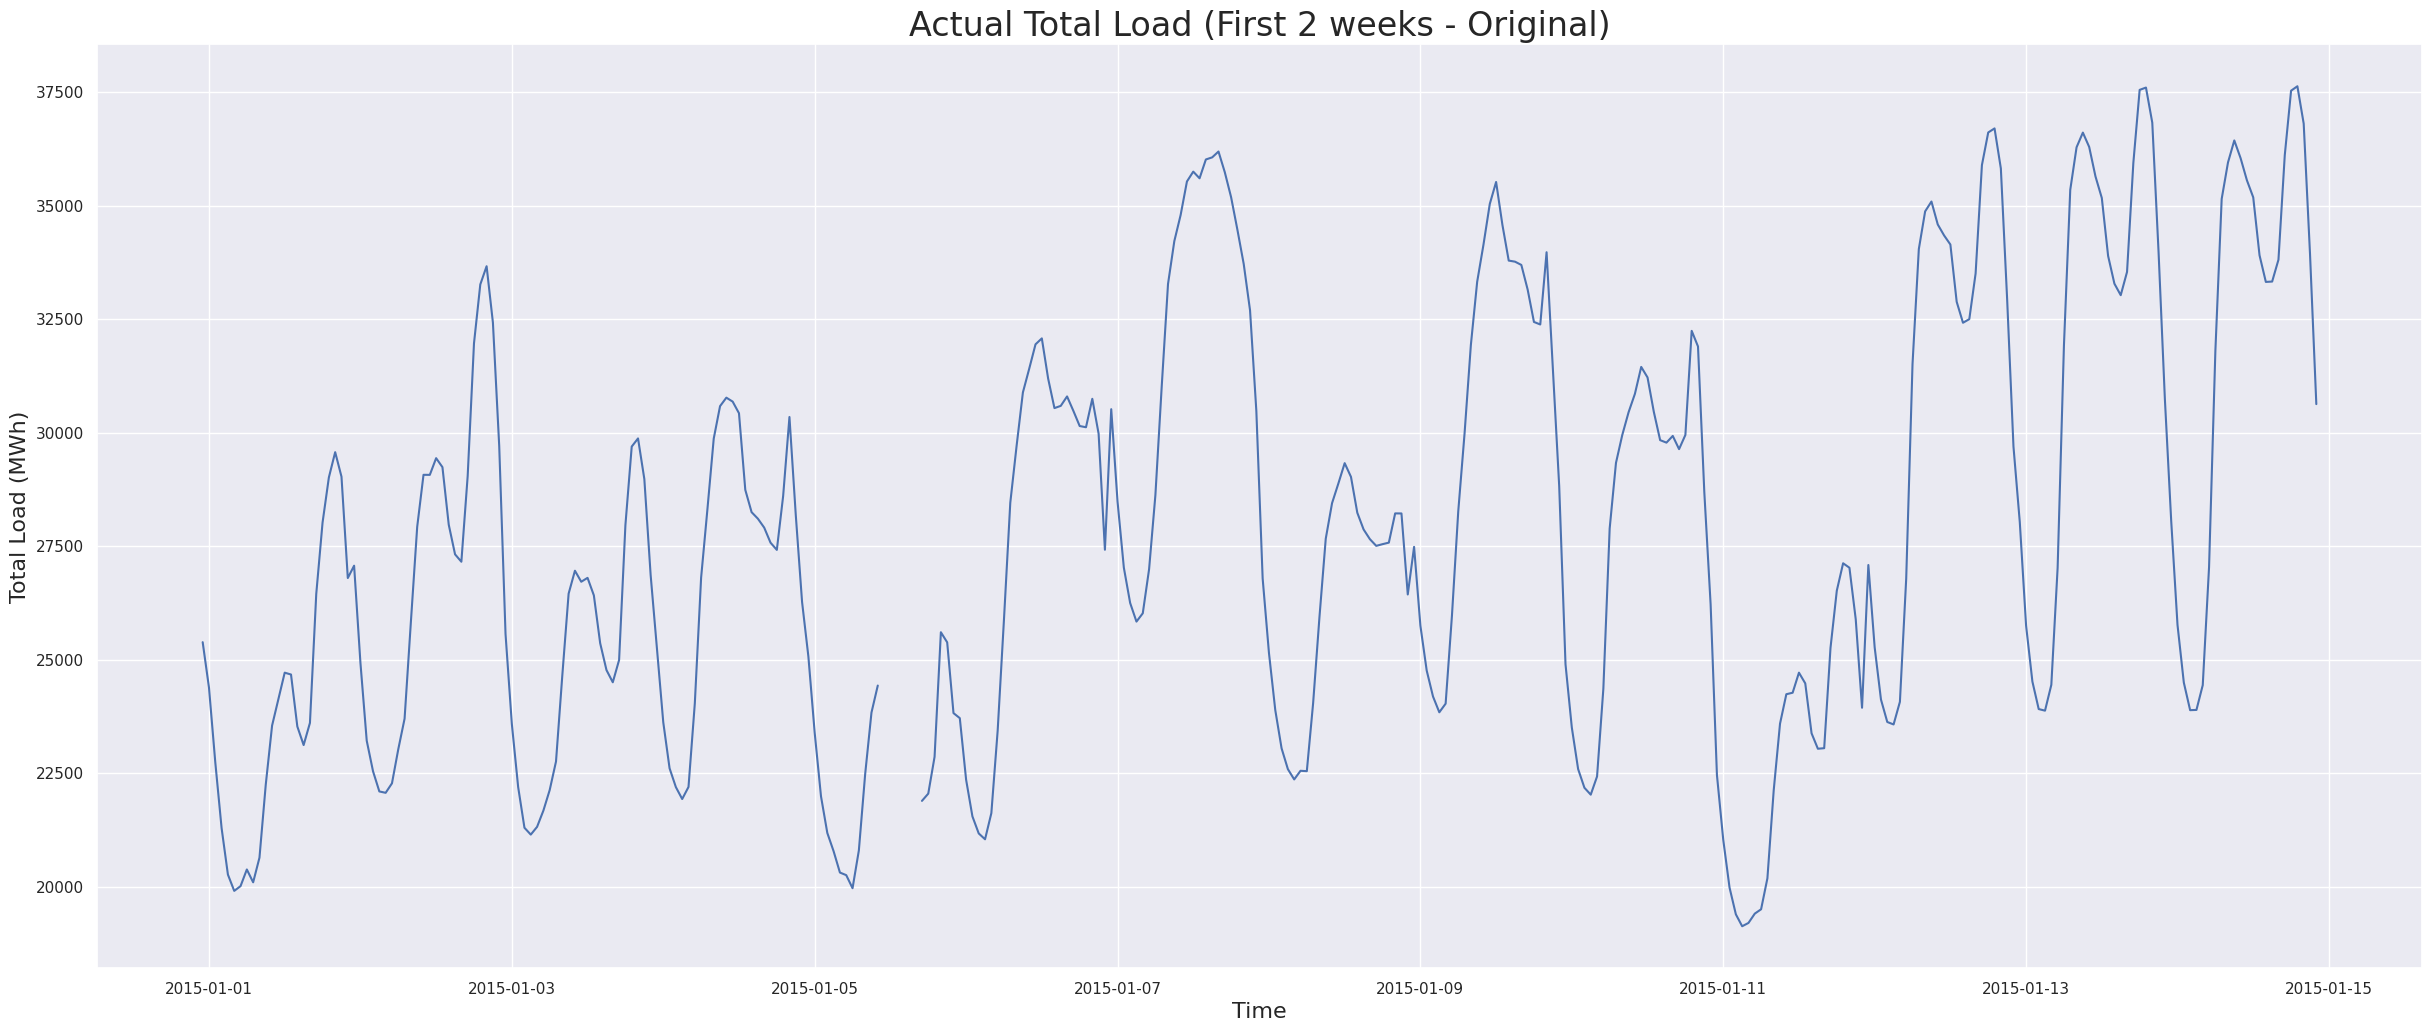

In [52]:
ax = plot_series(df=df_energy, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Original)', end=24*7*2)
plt.show()

We have visualized the first 2 weeks of the 'total load actual' column, and as we can see there are null values for a few hours. However, the number of the missing values and the behavior of the series indicate that an interpolation would fill the NaNs quite well. Let us further investigate if the null values coincide across the different columns. Let us display the last five rows.



If we manually searched through all of the columns, we would confirm that the null values in them is mostly coincide. The null values in 'actual total load' also coincide with the aforementioned columns, but also appear in other rows as well.
Using the linear forward interpolation we can handle the null values in df_energy.



In [53]:
# Filling null values using Forward Linear Interpolation

df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

2) Weather Dataset

In [54]:
df_weather.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.000000,178396.000000,178396.000000,1.783960e+05,178396.000000,178396.00000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000
mean,289.618605,288.330442,291.091267,1.069261e+03,68.423457,2.47056,166.591190,0.075492,0.000380,0.004763,25.073292,759.831902
std,8.026199,7.955491,8.612454,5.969632e+03,21.902888,2.09591,116.611927,0.398847,0.007288,0.222604,30.774129,108.733223
min,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,283.670000,282.483602,284.650000,1.013000e+03,53.000000,1.00000,55.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.00000,177.000000,0.000000,0.000000,0.000000,20.000000,800.000000
75%,295.150000,293.730125,297.150000,1.022000e+03,87.000000,4.00000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,315.600000,315.150000,321.150000,1.008371e+06,100.000000,133.00000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


there are some problems and outliers. In particular:

There is at least one outlier in the 'pressure' column as the maximum value is 1,008,371 hPa or approximately 100 MPa, which is too much high compared to the average value.
There is at least one outlier in the 'wind_speed' column as the maximum value is 133 m/s.
So, it would be a good idea to further examine those columns.

In [55]:
df_weather.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [56]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df


df_weather = df_convert_dtypes(df_weather, np.int64, np.float64)

In [57]:
df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['dt_iso'], axis=1)
df_weather = df_weather.set_index('time')

In [58]:
mean_weather_by_city = df_weather.groupby('city_name').mean()
mean_weather_by_city

<ipython-input-58-1b4512c4fed2>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_weather_by_city = df_weather.groupby('city_name').mean()


,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
city_name,,,,,,,,,,,,
Barcelona,289.848248,288.594704,291.021987,1284.010486,73.994221,2.786588,187.188043,0.117079,0.000327,0.000000,23.229648,760.917465
Bilbao,286.378489,284.916661,288.036687,1017.567439,79.089455,1.957470,159.883536,0.123493,0.001034,0.023455,43.960697,723.943228
Madrid,288.061071,286.824877,289.155600,1011.838448,59.776932,2.441696,173.293159,0.055083,0.000129,0.000029,22.397028,762.260264
Seville,293.105431,291.184103,295.962431,1018.504711,64.140732,2.483787,151.757179,0.045392,0.000180,0.000000,14.748770,771.409849
Valencia,290.780780,290.222277,291.355025,1015.973794,65.145113,2.692815,160.753820,0.035924,0.000226,0.000154,20.820999,781.228283


In [59]:
# Finding NaNs and duplicates in df_weather

print('There are {} missing values or NaNs in df_weather.'.format(df_weather.isnull().values.sum()))

temp_weather = df_weather.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_weather based on all columns.'.format(temp_weather))

There are 0 missing values or NaNs in df_weather.
There are 8622 duplicate rows in df_weather based on all columns.


In [60]:
print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

cities = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'.format(grouped_weather.get_group('{}'.format(city)).shape[0]),
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35145 observations in df_weather about city: Valencia.
There are 36267 observations in df_weather about city: Madrid.
There are 35951 observations in df_weather about city: Bilbao.
There are 35476 observations in df_weather about city:  Barcelona.
There are 35557 observations in df_weather about city: Seville.


In [61]:
# Create df_weather_2 and drop duplicate rows in df_weather

df_weather_2 = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                        keep='last').set_index('time')

df_weather = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                      keep='first').set_index('time')

In [62]:
print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]),
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35064 observations in df_weather about city: Valencia.
There are 35064 observations in df_weather about city: Madrid.
There are 35064 observations in df_weather about city: Bilbao.
There are 35064 observations in df_weather about city:  Barcelona.
There are 35064 observations in df_weather about city: Seville.


In [63]:
temp_weather = df_weather.reset_index().duplicated(subset=['time', 'city_name'],
                                                   keep='first').sum()
print('There are {} duplicate rows in df_weather ' \
      'based on all columns except "time" and "city_name".'.format(temp_weather))

There are 0 duplicate rows in df_weather based on all columns except "time" and "city_name".


In [64]:
df_weather = df_weather.drop(['weather_main', 'weather_id',
                              'weather_description', 'weather_icon'], axis=1)

### 3) Checking Outliers

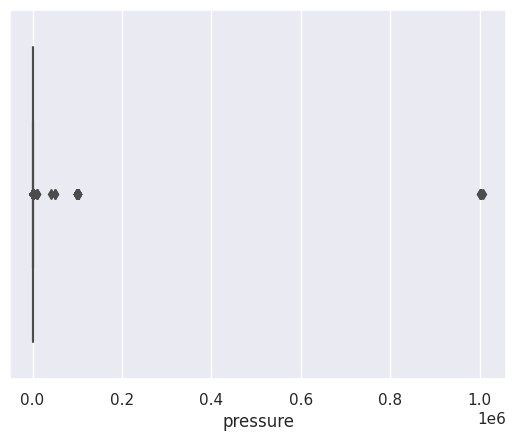

In [65]:
sns.boxplot(x=df_weather['pressure'])
plt.show()

In [66]:
# Replacing outliers in 'pressure' with NaNs

df_weather.loc[df_weather.pressure > 1051, 'pressure'] = np.nan
df_weather.loc[df_weather.pressure < 931, 'pressure'] = np.nan

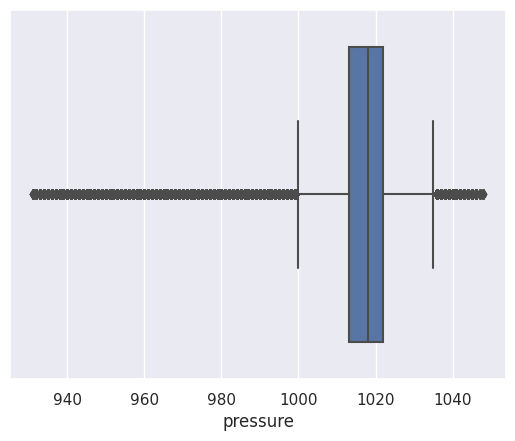

In [67]:
sns.boxplot(x=df_weather['pressure'])
plt.show()

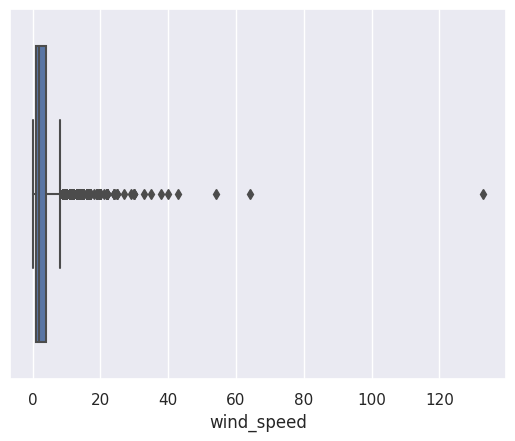

In [68]:
sns.boxplot(x=df_weather['wind_speed'])
plt.show()

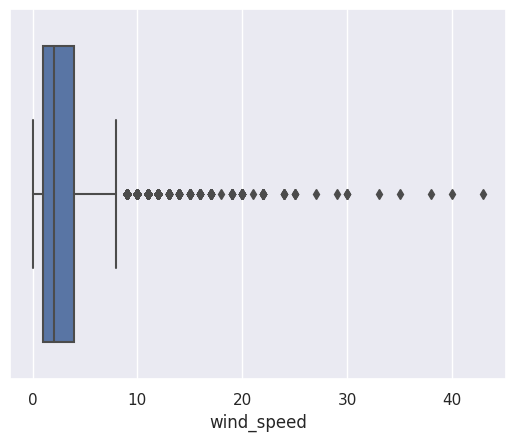

In [69]:
df_weather.loc[df_weather.wind_speed > 50, 'wind_speed'] = np.nan
sns.boxplot(x=df_weather['wind_speed'])
plt.show()

In [70]:
# Fill null values using interpolation

df_weather.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

### 4) Merging Datasets

In [71]:
df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]

In [72]:
df_final = df_energy

for df in dfs:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on=['time'], how='outer')
    df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)

df_final.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'temp_Barcelona',
       'temp_min_Barcelona', 'temp_max_Barcelona', 'pressure_Barcelona',
       'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona',
       'rain_1h_Barcelona', 'rain_3h_Barcelona', 'snow_3h_Barcelona',
       'clouds_all_Barcelona', 'temp_Bilbao', 'temp_min_Bilbao',
       'temp_max_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao',
       'wind_speed_Bilbao', 'wind_deg_Bilbao', 'rain_1h_Bilbao',
       'rain_3h_Bilbao', 'snow_3h_Bilbao', 'clo

#Time-Series Analysis

1) Visualziation and finding insights

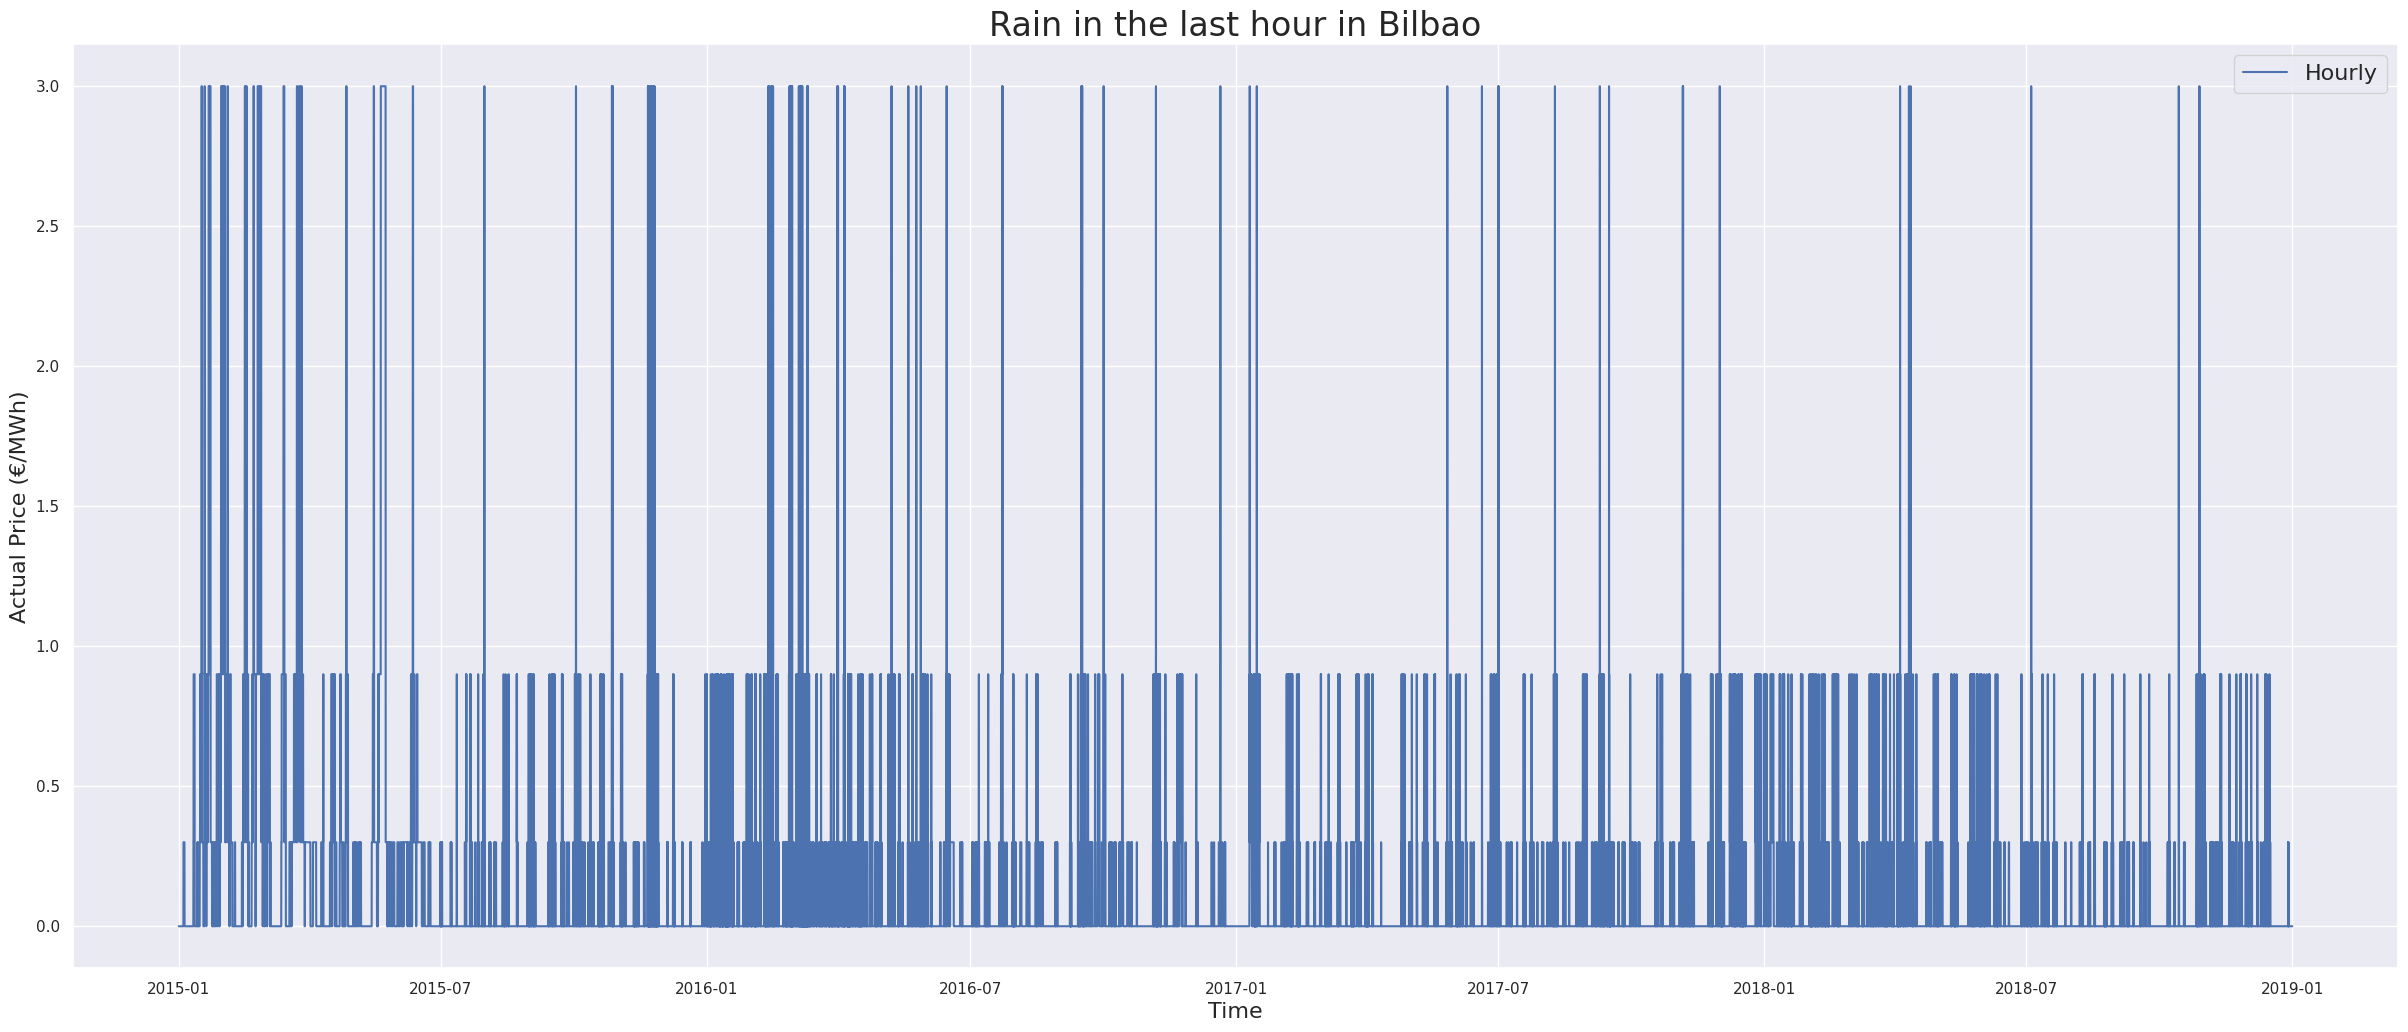

In [73]:
ax = plot_series(df_final, 'rain_1h_Bilbao',
                 label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Rain in the last hour in Bilbao')
plt.show()

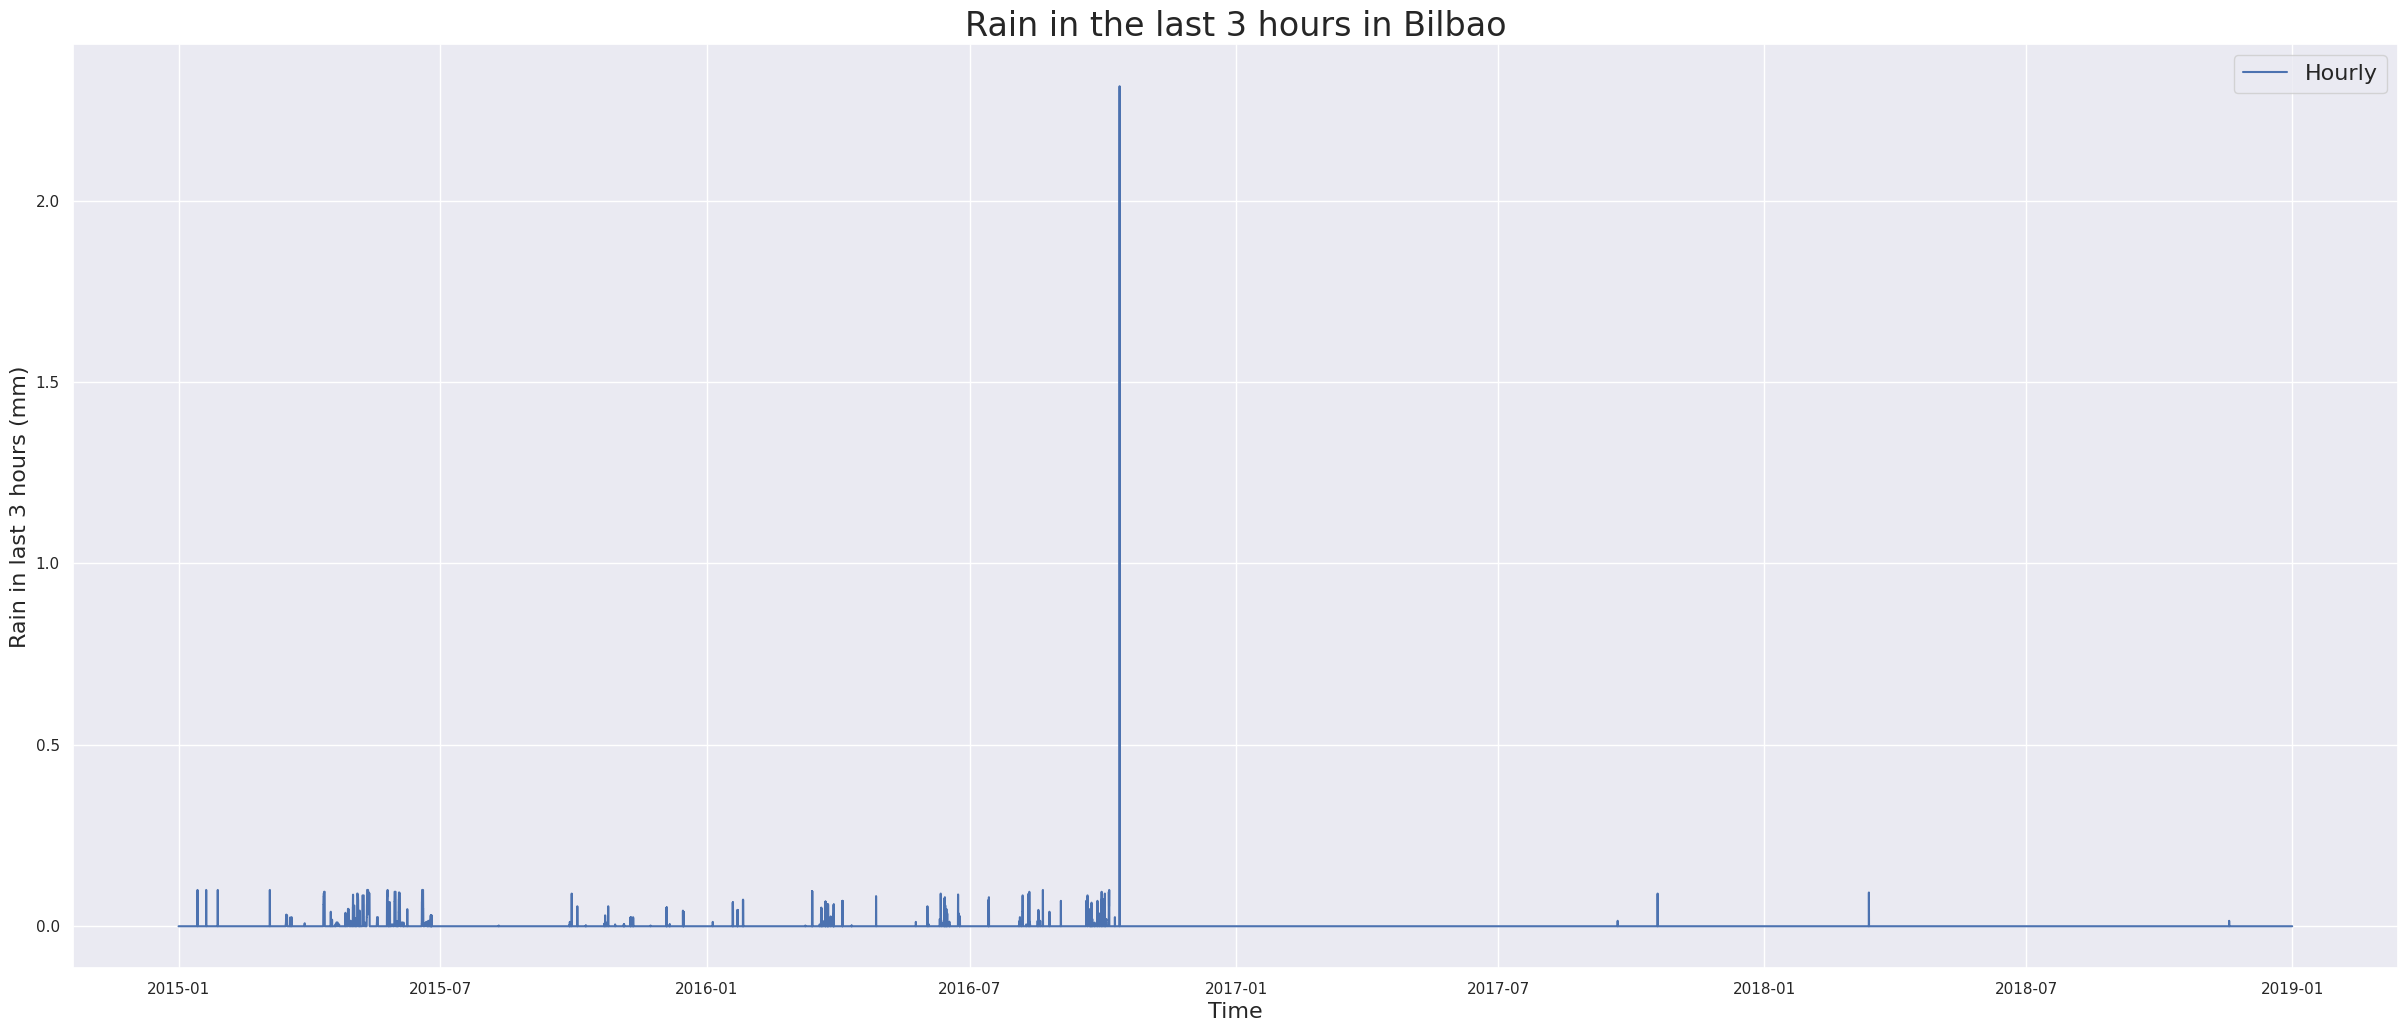

In [74]:
ax = plot_series(df_final, 'rain_3h_Bilbao',
                 label='Hourly', ylabel='Rain in last 3 hours (mm)',
                 title='Rain in the last 3 hours in Bilbao')
plt.show()

From the two figures, we can conclude that 'rain_3h' is an unreliable feature so we drop it from the dataset.

In [75]:
cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for city in cities:
    df_final = df_final.drop(['rain_3h_{}'.format(city)], axis=1)

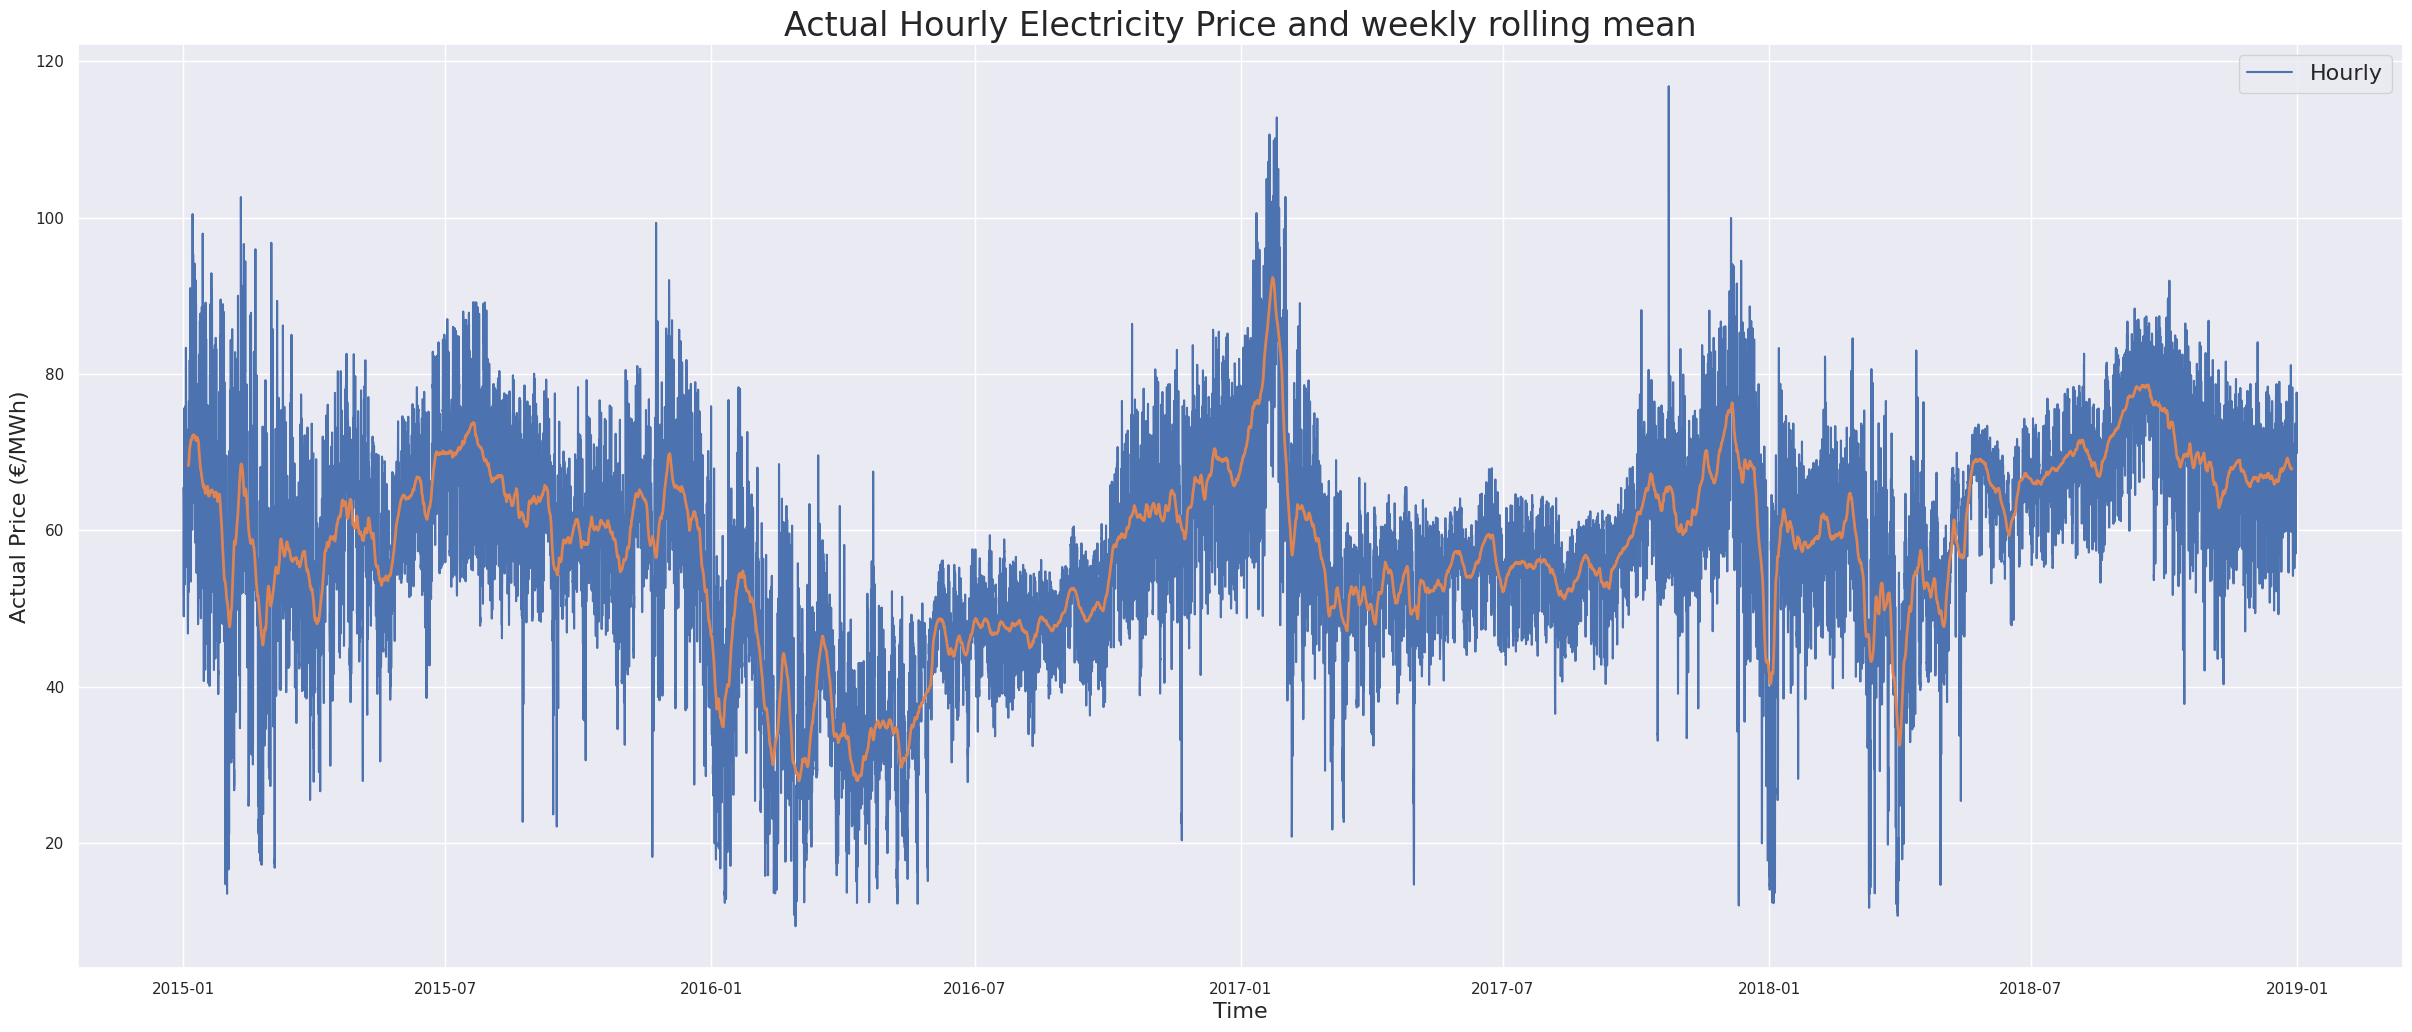

In [76]:
# Plot the hourly actual electricity price, along with the weekly rolling mean

rolling = df_final['price actual'].rolling(24*7, center=True).mean()
ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Actual Hourly Electricity Price and weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

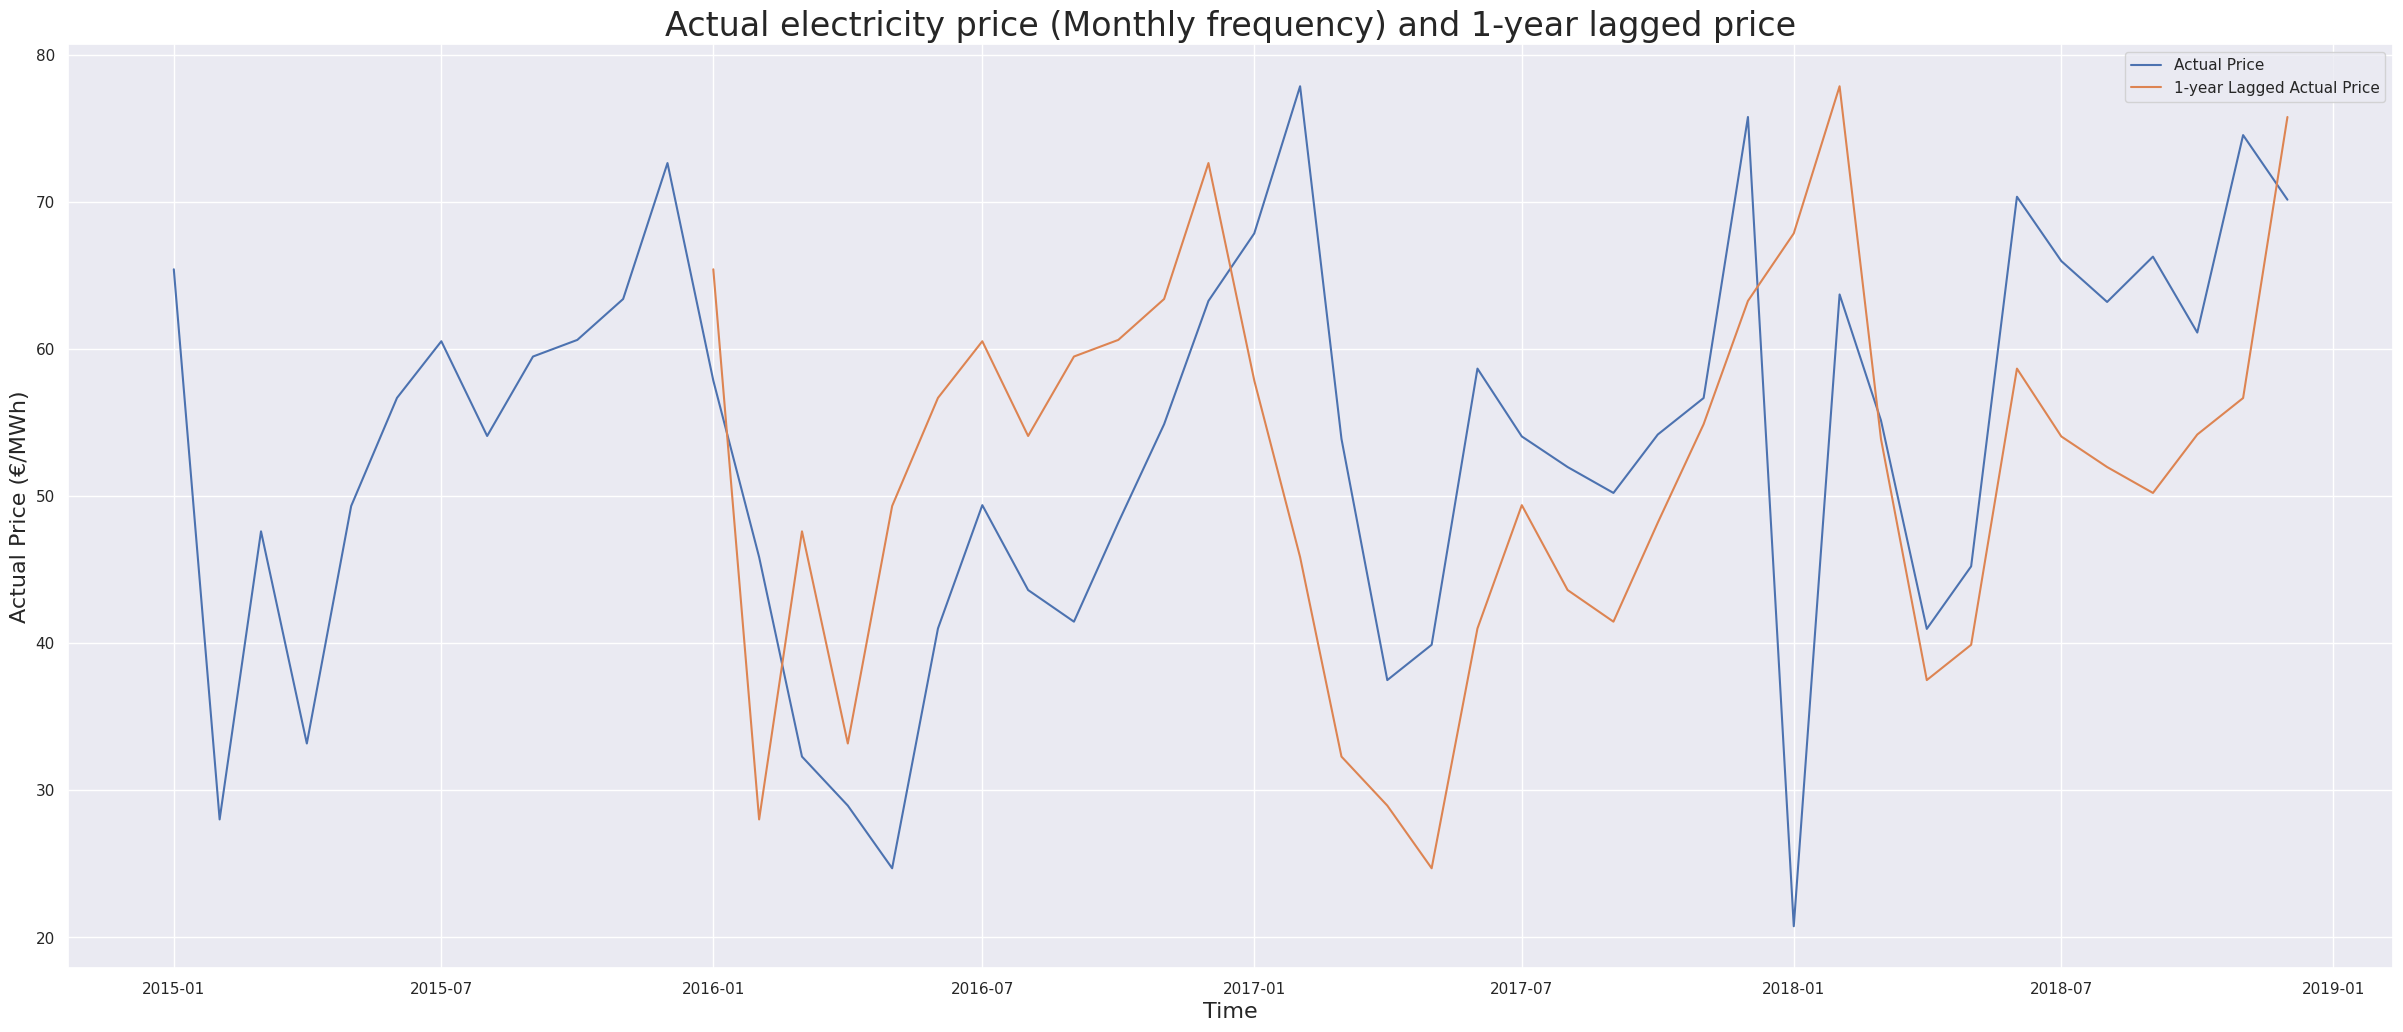

In [77]:

# Plot the electricity price (monthly frequence) along with its 1-year lagged series

monthly_price = df_final['price actual'].asfreq('M')
ax = plot_series(series=monthly_price, ylabel='Actual Price (€/MWh)',
                 title='Actual electricity price (Monthly frequency) and 1-year lagged price')
shifted = df_final['price actual'].asfreq('M').shift(12)
ax.plot(shifted, label='Hourly')
ax.legend(['Actual Price', '1-year Lagged Actual Price'])
plt.show()



The figure above displays the resampled monthly frequency of the actual electricity price, acompanied by  its 1-year lagged monthly frequency. The plot indicates that there are clear seasonal patterns at the monthly scale, as certain "spikes" in the time-series occur in the same months every year. Therefore, creating a new feature for the months would be useful.

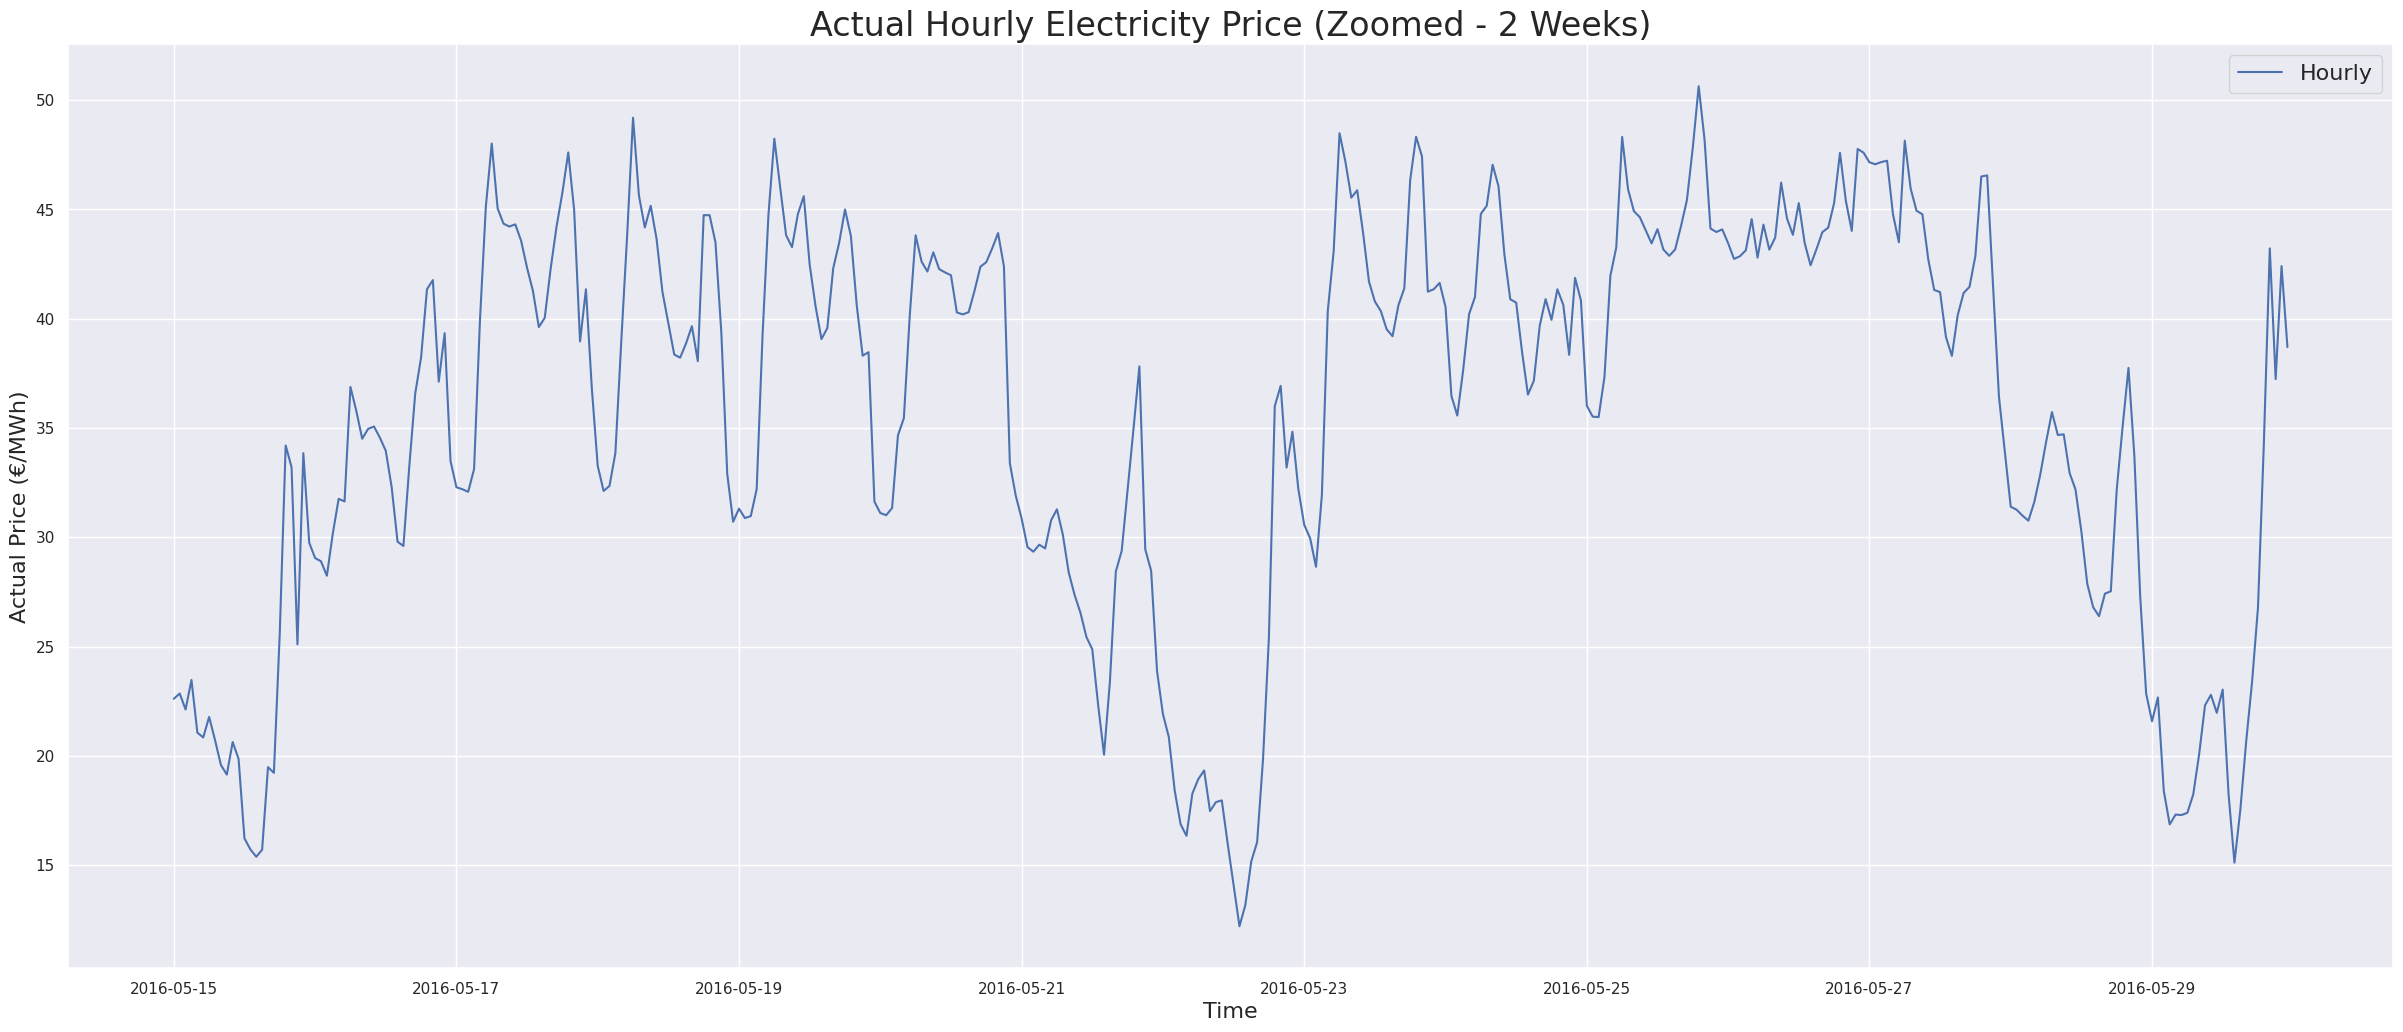

In [78]:
# actual electricity price at a weekly scale

ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 start=1 + 24 * 500, end=1 + 24 * 515,
                 title='Actual Hourly Electricity Price (Zoomed - 2 Weeks)')
plt.show()

2) Decoposition ans Stationary Test

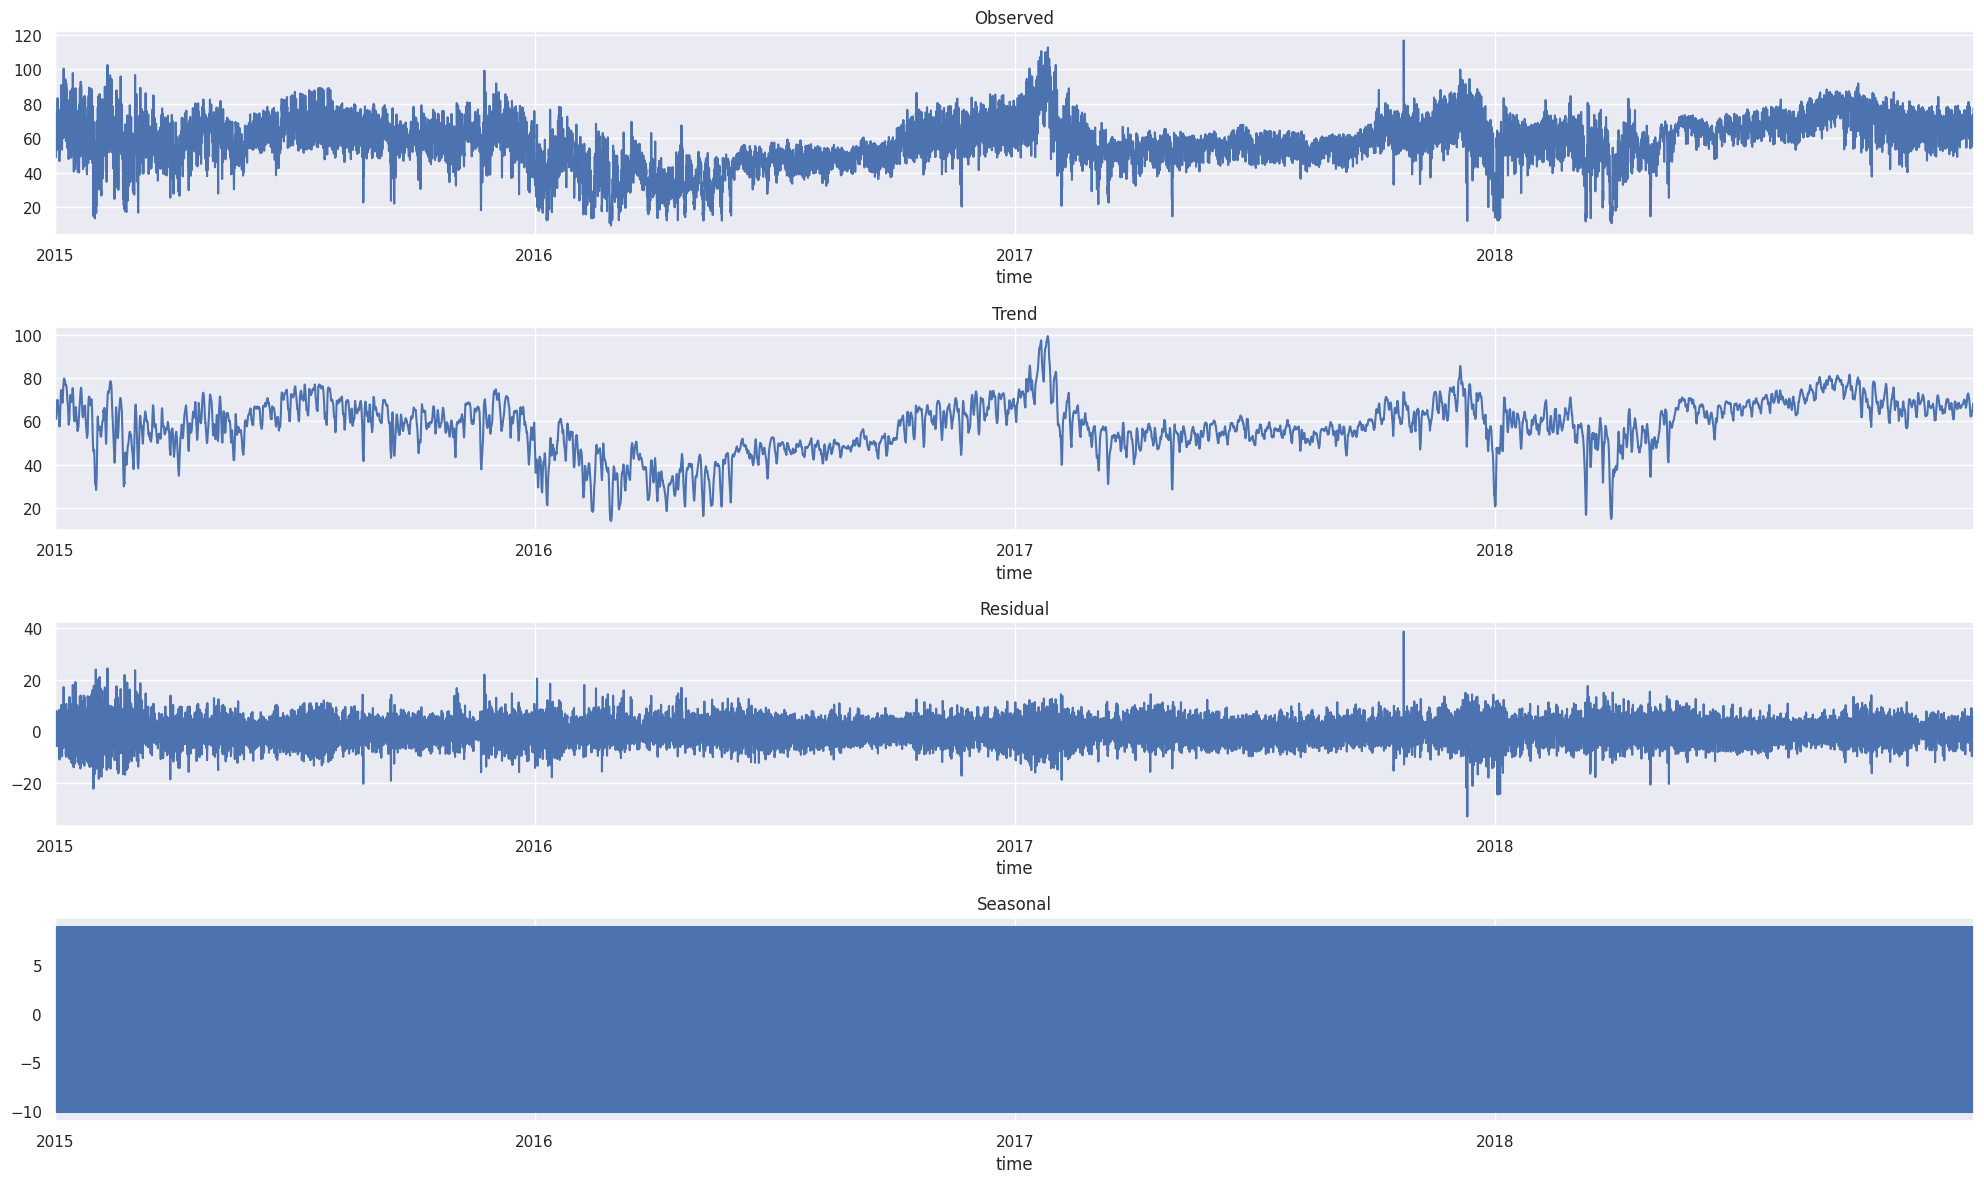

In [79]:
# Decompose the electricity price time series

res = sm.tsa.seasonal_decompose(df_energy['price actual'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()


*   **Trend**: A trend refers to a long-term pattern or tendency in the data. It represents the overall direction of the series over a long period of time. A trend can be upward (increasing), downward (decreasing), or flat (no change).

*   **Seasonal**: A seasonal component refers to a pattern that repeats itself at regular intervals, such as weekly, monthly, or yearly.

*   Residual: The residual component, also known as the error term, represents the random fluctuations in the data that are not accounted for by the trend and seasonal components.








**The Augmented Dickey-Fuller (ADF)** : ADF test is commonly used to check whether a time series is stationary or not. Stationarity is an important concept in time series analysis, which means that the statistical properties of the time series remain constant over time.

The ADF test is based on the idea of testing for the presence of a unit root in the time series. A unit root means that the series has a root or a solution that equals 1, which indicates that the series is not stationary. The test statistic from the ADF test is compared to critical values to determine whether to reject or fail to reject the null hypothesis.

If the null hypothesis is rejected, it indicates that the time series is stationary and does not have a unit root. If the null hypothesis cannot be rejected, it suggests that the series is not stationary and may require further analysis or differencing to make it stationary.

**Null Hypothesis H0** : There is a unit root in the time series, i.e. the series is autocorrelated with (r=1), a time dependent structure and thus, is **not stationary**.

**Alternate Hypothesis H1**: The time series has no unit root and is either stationary or can be made stationary using differencing.

In [80]:
y = df_final['price actual']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))



ADF Statistic: -9.147016
p-value: 0.000000
#Lags used: 50
Critical Value (1%): -3.430537
Critical Value (5%): -2.861623
Critical Value (10%): -2.566814


The ADF statistic value (-9.147) is less than the critical value at 1% (-3.431) and thus the null hypothesis H0 will be rejected with a significance level 1% (99% certainty), meaning that the time series is either stationary or could be made stationary.

Another Stationary Test :
The Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test, which is the opposite logic from ADF test and checks for stationarity. Its hypotheses are the following:

**Null Hypothesis H0**: The time series is level, i.e. it is **stationary** around a constant.

**Alternate Hypothesis H1**: There is a unit root in the time series and thus it not stationary.

In [82]:
kpss_test = kpss(y, regression='c', nlags='legacy')
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

KPSS Statistic: 7.957007
p-value: 0.010000
#Lags used: 52
Critical Value (10%): 0.347000
Critical Value (5%): 0.463000
Critical Value (2.5%): 0.574000
Critical Value (1%): 0.739000


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(



3) Correlation Type


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


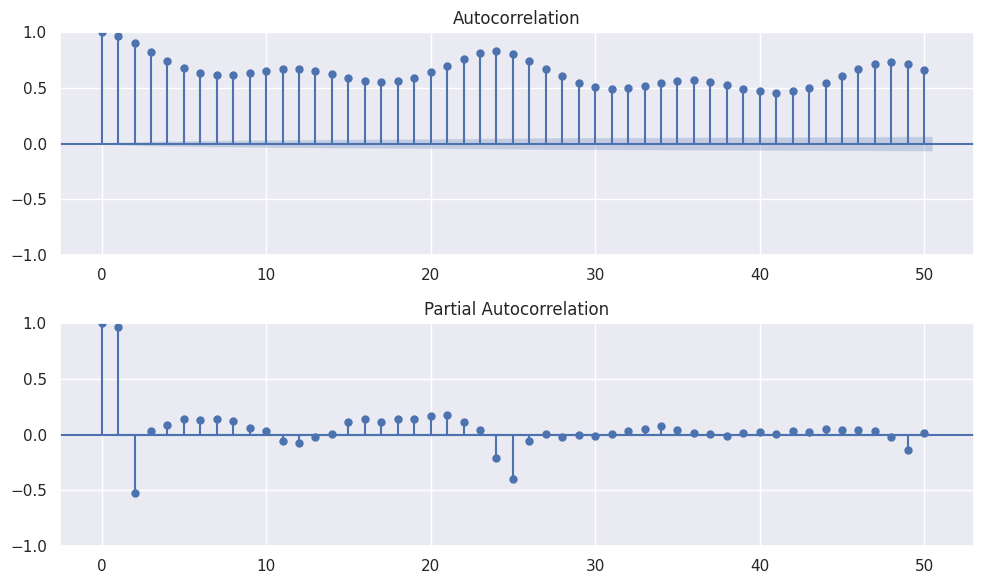

In [83]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df_final['price actual'], lags=50, ax=ax1)
plot_pacf(df_final['price actual'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

The partial autocorrelation plot of the electricity price time series clearly indicates the most prominent direct relationships. These relationships are strongest with observations at t-1, t-2, t-24, and t-25 time-steps, gradually diminishing beyond this range. As a result, we intend to incorporate the 25 preceding values of each time series as features for our models.

However, an even more advantageous approach could involve selecting specific past values—observations at particular time-lags—of a given feature. This selection would be based on the cross-correlation analysis between the electricity price and each feature in the dataset. For instance, consider the cross-correlation between the electricity price and the total load below. Notably, there are several time-lags with correlations close to zero, presenting an opportunity for omission.

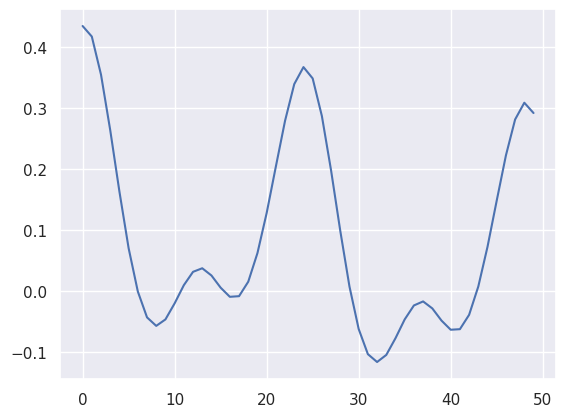

In [84]:
cross_corr = ccf(df_final['total load actual'], df_final['price actual'])
plt.plot(cross_corr[0:50])
plt.show()

In [86]:
# For simplicity, we will just work with the correlations between the electricity price and the other features at each given hour.


correlations = df_final.corr(method='pearson')
print(correlations['price actual'].sort_values(ascending=False).to_string())

price actual                                   1.000000
price day ahead                                0.732155
generation fossil hard coal                    0.465637
generation fossil gas                          0.461452
total load actual                              0.435253
generation fossil brown coal/lignite           0.363993
generation fossil oil                          0.285050
generation other renewable                     0.255551
pressure_Barcelona                             0.249177
pressure_Bilbao                                0.194063
generation waste                               0.168710
generation biomass                             0.142671
temp_min_Valencia                              0.133141
pressure_Valencia                              0.109812
temp_min_Barcelona                             0.103726
generation other                               0.099914
generation solar                               0.098529
temp_max_Madrid                                0

Upon examining the provided information, intriguing correlations have already emerged between the energy price we aim to predict and other features. Notably, the total energy load and energy generation from fossil fuel-related sources display a positive correlation with electricity prices. Conversely, wind speed in nearly all cities and the consumption of storage energy via hydroelectric pumping show a negative correlation with energy prices.

To proceed, we will exclude 'snow_3h_Barcelona' and 'snow_3h_Seville' from consideration. These two features yield NaN correlations with the actual electricity price, warranting their removal from the analysis.

In [88]:
df_final = df_final.drop(['snow_3h_Barcelona', 'snow_3h_Seville'], axis=1)

In [89]:
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())


generation fossil brown coal/lignite  generation fossil hard coal             0.768831
generation fossil hard coal           generation fossil brown coal/lignite    0.768831
temp_Barcelona                        temp_min_Barcelona                      0.970264
                                      temp_max_Barcelona                      0.976904
                                      temp_Bilbao                             0.866727
                                      temp_min_Bilbao                         0.867970
                                      temp_max_Bilbao                         0.828347
                                      temp_Madrid                             0.903996
                                      temp_min_Madrid                         0.874548
                                      temp_max_Madrid                         0.899010
                                      temp_Seville                            0.841910
                                      temp_



What we can observe, is that apart from the amount of energy generated by fossil brown coal/lignit and hard coal, the most correlated features have to do with the temperatures among the different cities, as well the "secondary" information we have about the temperature of each individual city (i.e. the minimunm and maximum temperature).


# Feature Engineering

In [90]:
# Generate 'hour', 'weekday' and 'month' features

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    df_final.loc[position, 'hour'] = hour
    df_final.loc[position, 'weekday'] = weekday
    df_final.loc[position, 'month'] = month



A very useful feature that we will generate, has to do with the business hours, i.e. whether businesses are open or not in a given hour. However, there is a certain peculiarity in Spain as the 9AM-5PM working day is not generally followed by all types of businesses, due to a lunch break (known as "siesta") in between. The most usual business hours are from Monday-Saturday, from 9:30AM-1:30PM and then again from 4:30PM-8PM.

Therefore, the value of the 'business hour' will be equal to '2' if the given hour is within the business hours, equal to '1' if the given hour is within the "siesta" in between and equal to '0' for all other given hours.


In [91]:
for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
        df_final.loc[position, 'business hour'] = 2
    elif (hour >= 14 and hour <= 16):
        df_final.loc[position, 'business hour'] = 1
    else:
        df_final.loc[position, 'business hour'] = 0



However, we have generated the 'business hour' feature in such a way which also includes weekends, on which fewer -or different types of- businesses are open. Thus, it is useful to also generate another feature, 'weekend', which will distuingish weekdays and weekends, as well as make a distinction between Saturdays and Sundays.

In particular, for a particular given hour, the value of 'weekend' will be equal to '0', if the hours is in a weekday, equal to '1' if the hour is in a Saturday and equal to '2' if the hour is in a Sunday.


In [92]:
for i in range(len(df_final)):
    position = df_final.index[i]
    weekday = position.weekday()
    if (weekday == 6):
        df_final.loc[position, 'weekday'] = 2
    elif (weekday == 5):
        df_final.loc[position, 'weekday'] = 1
    else:
        df_final.loc[position, 'weekday'] = 0

In [93]:
# Generate 'temp_range' for each city

cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for i in range(len(df_final)):
    position = df_final.index[i]
    for city in cities:
        temp_max = df_final.loc[position, 'temp_max_{}'.format(city)]
        temp_min = df_final.loc[position, 'temp_min_{}'.format(city)]
        df_final.loc[position, 'temp_range_{}'.format(city)] = abs(temp_max - temp_min)



After seeing that there is a high correlation among the temperatures of the different cities, we will also try creating a weighted temperature features by taking into account each city's population:

    Madrid: 6,155,116
    Barcelona: 5,179,243
    Valencia: 1,645,342
    Seville: 1,305,342
    Bilbao: 987,000



In [94]:
total_pop = 6155116 + 5179243 + 1645342 + 1305342 + 987000

weight_Madrid = 6155116 / total_pop
weight_Barcelona = 5179243 / total_pop
weight_Valencia = 1645342 / total_pop
weight_Seville = 1305342 / total_pop
weight_Bilbao = 987000 / total_pop

In [96]:
cities_weights = {'Madrid': weight_Madrid,
                  'Barcelona': weight_Barcelona,
                  'Valencia': weight_Valencia,
                  'Seville': weight_Seville,
                  'Bilbao': weight_Bilbao}


for i in range(len(df_final)):
    position = df_final.index[i]
    temp_weighted = 0
    for city in cities:
        temp = df_final.loc[position, 'temp_{}'.format(city)]
        temp_weighted += temp * cities_weights.get('{}'.format(city))
    df_final.loc[position, 'temp_weighted'] = temp_weighted

In [97]:
df_final['generation coal all'] = df_final['generation fossil hard coal'] + df_final['generation fossil brown coal/lignite']

In [98]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [100]:
train_end_idx = 27048
cv_end_idx = 31056
test_end_idx = 35064

X = df_final[df_final.columns.drop('price actual')].values
y = df_final['price actual'].values

y = y.reshape(-1, 1)

In [103]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

MinMaxScaler()

In [105]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)


MinMaxScaler(copy=True, feature_range=(0, 1))



MinMaxScaler()

In [106]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)



In [107]:
pca = PCA()
X_pca = pca.fit(X_norm[:train_end_idx])

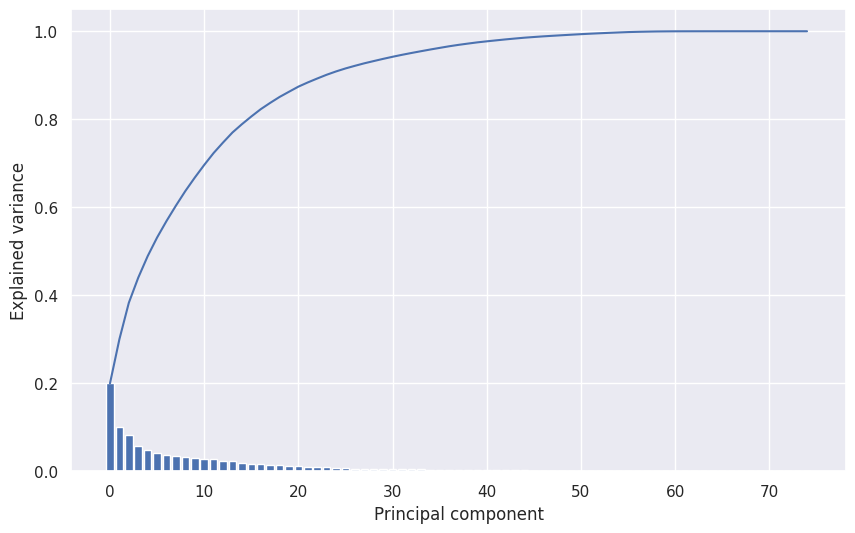

In [108]:
num_components = len(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()

In [109]:
pca = PCA(n_components=0.80)
pca.fit(X_norm[:train_end_idx])
X_pca = pca.transform(X_norm)



In [110]:
dataset_norm = np.concatenate((X_pca, y_norm), axis=1)

past_history = 24
future_target = 0

In [111]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history,
                                     future_target, step=1, single_step=True)


X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history,
                                 future_target, step=1, single_step=True)

X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history,
                                   future_target, step=1, single_step=True)

In [112]:
batch_size = 32
buffer_size = 1000



In [113]:


train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)



In [114]:
input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [115]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)

#4) Electricity Price Forecasting

In [116]:
def plot_model_rmse_and_loss(history):

    # Evaluate train and validation accuracies and losses

    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Visualize epochs vs. train and validation accuracies and losses

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')

    plt.show()

### 4.1) LSTM

In [117]:
tf.keras.backend.clear_session()

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape,
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [118]:
history = multivariate_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping,
                                           model_checkpoint])

Epoch 1/120
845/845 [==============================] - 16s 8ms/step - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0756
Epoch 2/120
845/845 [==============================] - 6s 7ms/step - loss: 0.0024 - root_mean_squared_error: 0.0492 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0520
Epoch 3/120
845/845 [==============================] - 8s 10ms/step - loss: 0.0020 - root_mean_squared_error: 0.0445 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0472
Epoch 4/120
845/845 [==============================] - 8s 10ms/step - loss: 0.0017 - root_mean_squared_error: 0.0407 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0438
Epoch 5/120
845/845 [==============================] - 8s 9ms/step - loss: 0.0015 - root_mean_squared_error: 0.0382 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0412
Epoch 6/120
845/845 [==============================] - 6s 7ms/step - loss: 0.0013 - root_mean_squared_error: 0.0359 - val_loss: 0.00

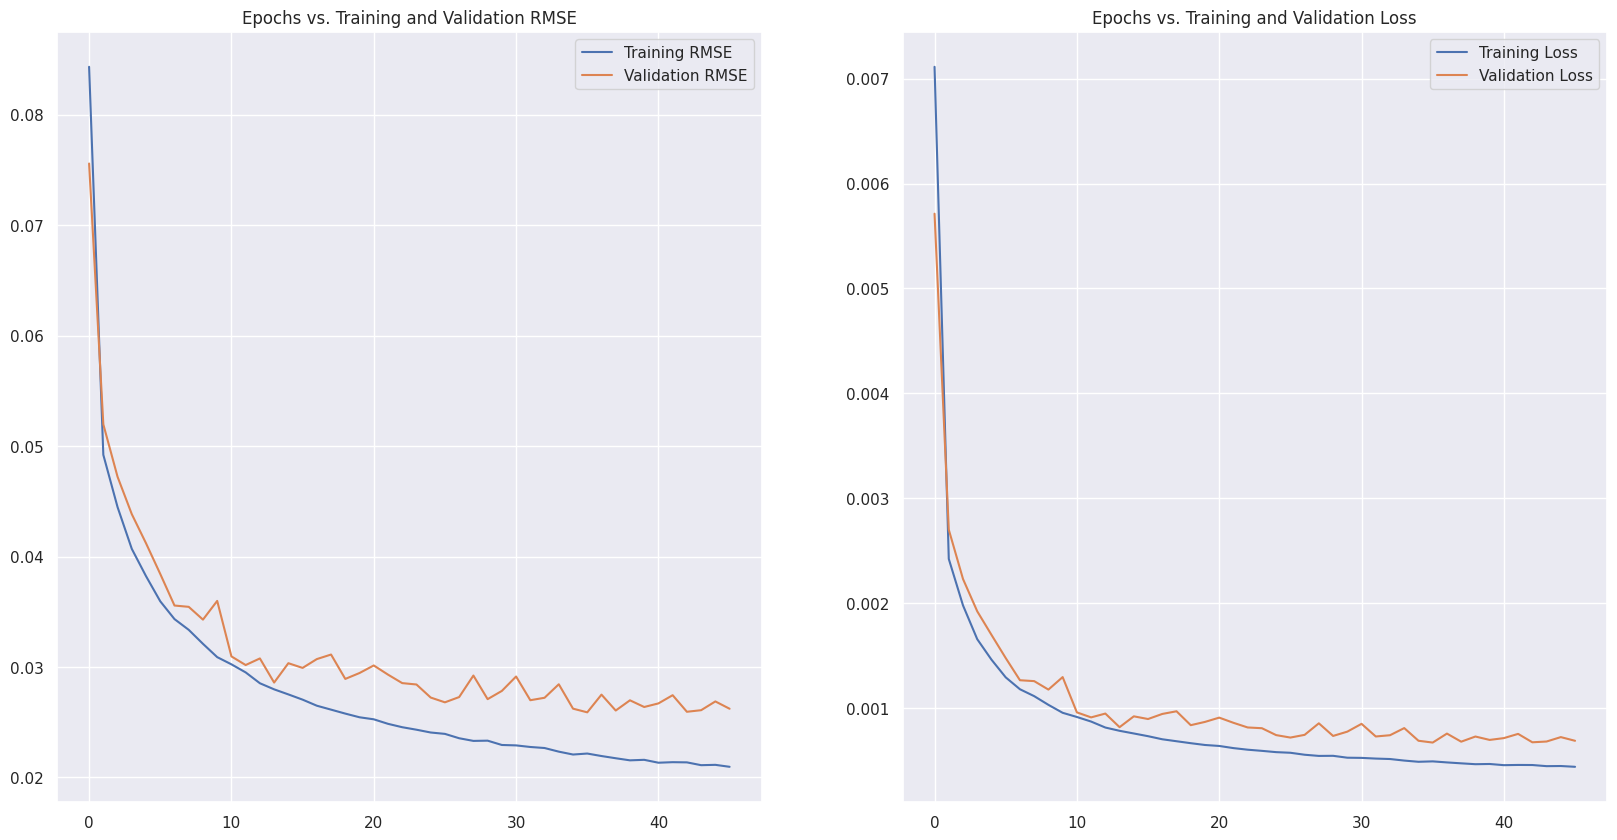

In [119]:
plot_model_rmse_and_loss(history)

In [120]:
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))
print('RMSE of hour-ahead electricity price LSTM forecast: {}'
      .format(round(rmse_lstm, 3)))

125/125 [==============================] - 1s 3ms/step
RMSE of hour-ahead electricity price LSTM forecast: 2.397


## 4.2) Stacked LSTM

In [121]:
tf.keras.backend.clear_session()

multivariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(250, input_shape=input_shape,
         return_sequences=True),
    LSTM(150, return_sequences=True),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_stacked_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=3e-3, amsgrad=True)

multivariate_stacked_lstm.compile(loss=loss,optimizer=optimizer,metrics=metric)

history = multivariate_stacked_lstm.fit(train, epochs=120,validation_data=validation,callbacks=[early_stopping, model_checkpoint])



Epoch 1/120
845/845 [==============================] - 18s 14ms/step - loss: 0.0050 - root_mean_squared_error: 0.0665 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0613
Epoch 2/120
845/845 [==============================] - 12s 14ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0552
Epoch 3/120
845/845 [==============================] - 8s 10ms/step - loss: 0.0018 - root_mean_squared_error: 0.0426 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0495
Epoch 4/120
845/845 [==============================] - 9s 10ms/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0416
Epoch 5/120
845/845 [==============================] - 9s 11ms/step - loss: 0.0012 - root_mean_squared_error: 0.0344 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 6/120
845/845 [==============================] - 7s 8ms/step - loss: 0.0010 - root_mean_squared_error: 0.0318 - val_loss: 

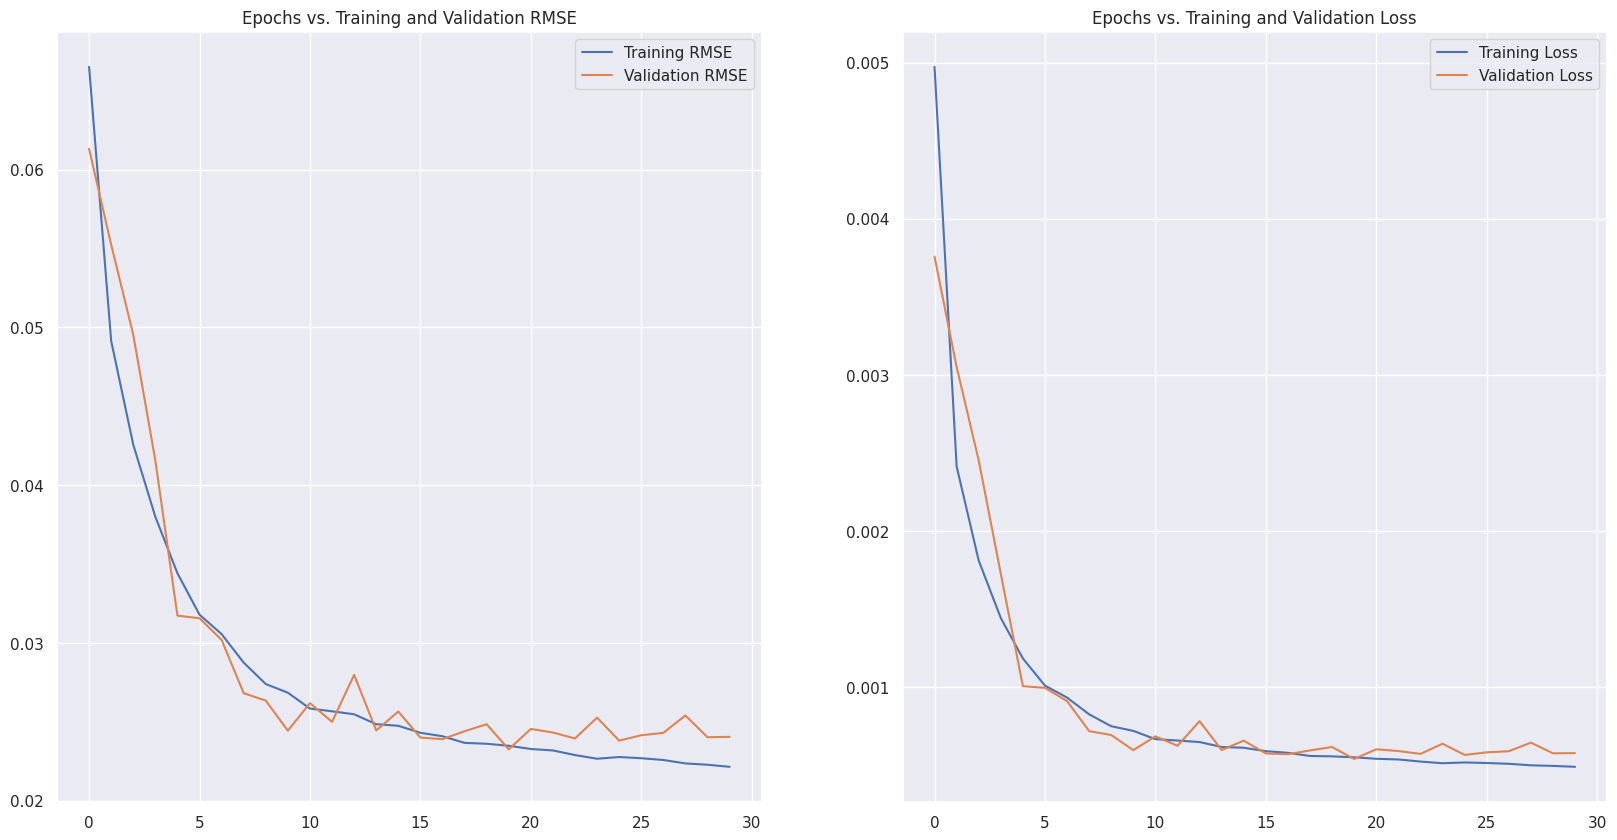

In [122]:
plot_model_rmse_and_loss(history)

In [123]:
multivariate_stacked_lstm = tf.keras.models.load_model('multivariate_stacked_lstm.h5')

forecast = multivariate_stacked_lstm.predict(X_test)
multivariate_stacked_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_stacked_lstm = sqrt(mean_squared_error(y_test_inv,
                                                 multivariate_stacked_lstm_forecast))
print('RMSE of hour-ahead electricity price multivariate Stacked LSTM forecast: {}'
      .format(round(rmse_mult_stacked_lstm, 3)))

125/125 [==============================] - 1s 3ms/step
RMSE of hour-ahead electricity price multivariate Stacked LSTM forecast: 2.238


## 4.3) CNN

In [124]:
tf.keras.backend.clear_session()

multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=48, kernel_size=2,
           strides=1, padding='causal',
           activation='relu',
           input_shape=input_shape),
    Flatten(),
    Dense(48, activation='relu'),
    Dense(1)])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_cnn.compile(loss=loss,optimizer=optimizer,metrics=metric)


history = multivariate_cnn.fit(train, epochs=120,validation_data=validation,callbacks=[early_stopping, model_checkpoint])


Epoch 1/120
845/845 [==============================] - 10s 4ms/step - loss: 0.0057 - root_mean_squared_error: 0.0707 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0704
Epoch 2/120
845/845 [==============================] - 3s 4ms/step - loss: 0.0021 - root_mean_squared_error: 0.0454 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0492
Epoch 3/120
845/845 [==============================] - 3s 4ms/step - loss: 0.0014 - root_mean_squared_error: 0.0381 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0431
Epoch 4/120
845/845 [==============================] - 3s 4ms/step - loss: 0.0012 - root_mean_squared_error: 0.0343 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0397
Epoch 5/120
845/845 [==============================] - 3s 4ms/step - loss: 0.0010 - root_mean_squared_error: 0.0316 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 6/120
845/845 [==============================] - 4s 5ms/step - loss: 8.7375e-04 - root_mean_squared_error: 0.0296 - val_loss: 0.

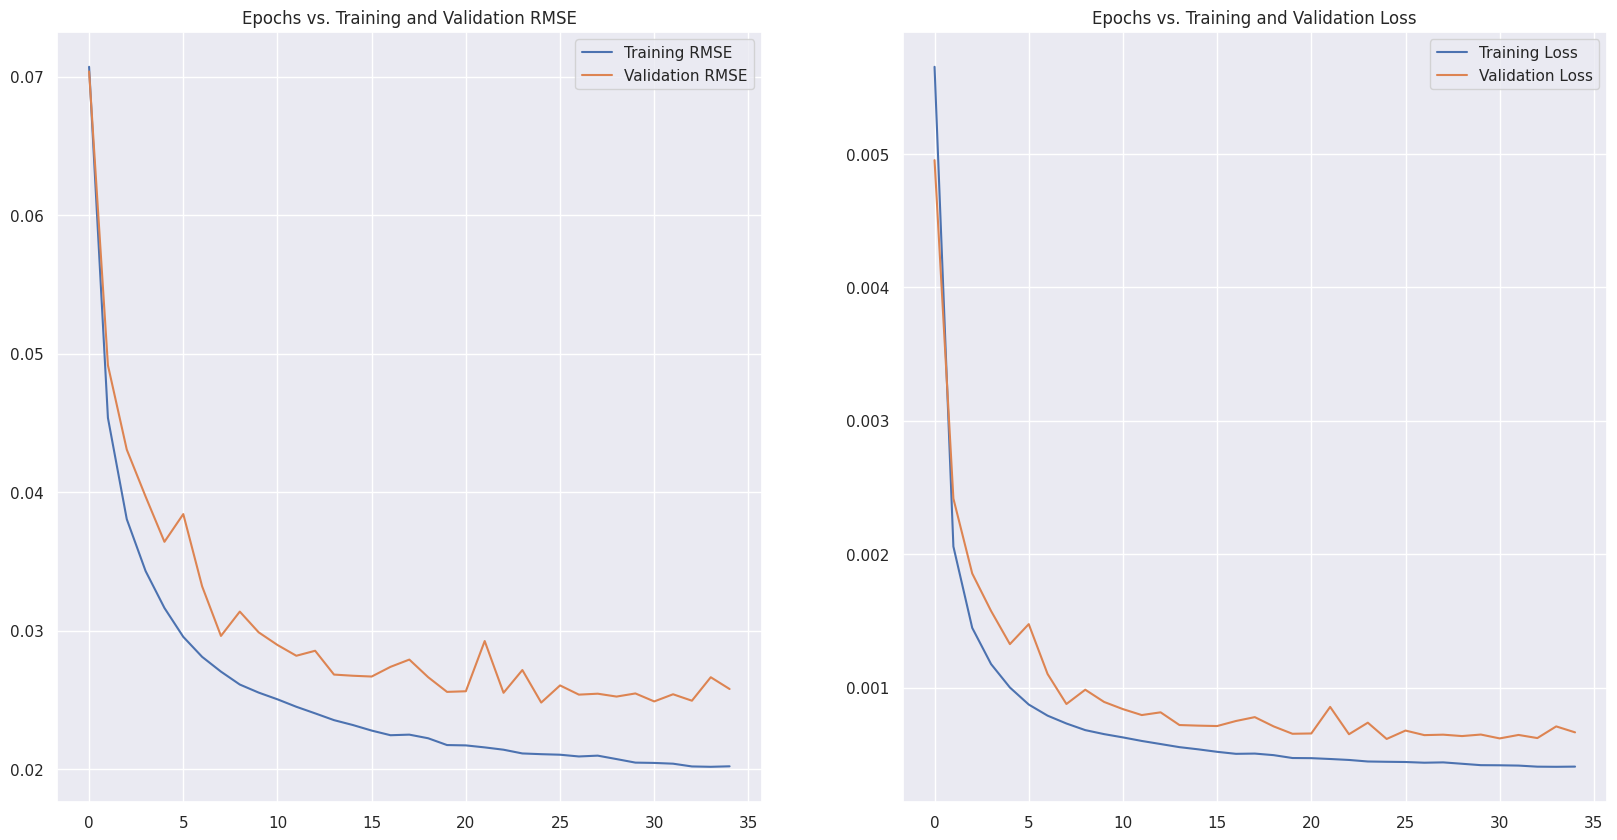

In [125]:
plot_model_rmse_and_loss(history)

In [126]:
multivariate_cnn = tf.keras.models.load_model('multivariate_cnn.h5')

forecast = multivariate_cnn.predict(X_test)
multivariate_cnn_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_cnn_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN forecast: {}'
      .format(round(rmse_mult_cnn, 3)))

125/125 [==============================] - 0s 2ms/step
RMSE of hour-ahead electricity price multivariate CNN forecast: 2.532


## 4.4) CNN - LSTM

In [127]:
tf.keras.backend.clear_session()

multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu',
           input_shape=input_shape),
    LSTM(100, return_sequences=True),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn_lstm.h5', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(lr=4e-3, amsgrad=True)

multivariate_cnn_lstm.compile(loss=loss,optimizer=optimizer,metrics=metric)

history = multivariate_cnn_lstm.fit(train, epochs=120,validation_data=validation,callbacks=[early_stopping,
                                    model_checkpoint])

Epoch 1/120
845/845 [==============================] - 9s 8ms/step - loss: 0.0042 - root_mean_squared_error: 0.0609 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0625
Epoch 2/120
845/845 [==============================] - 5s 6ms/step - loss: 0.0017 - root_mean_squared_error: 0.0406 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0498
Epoch 3/120
845/845 [==============================] - 5s 6ms/step - loss: 0.0012 - root_mean_squared_error: 0.0349 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 4/120
845/845 [==============================] - 5s 6ms/step - loss: 9.3067e-04 - root_mean_squared_error: 0.0305 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0336
Epoch 5/120
845/845 [==============================] - 6s 7ms/step - loss: 8.0379e-04 - root_mean_squared_error: 0.0284 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0344
Epoch 6/120
845/845 [==============================] - 5s 6ms/step - loss: 6.9710e-04 - root_mean_squared_error: 0.0264 - val_l

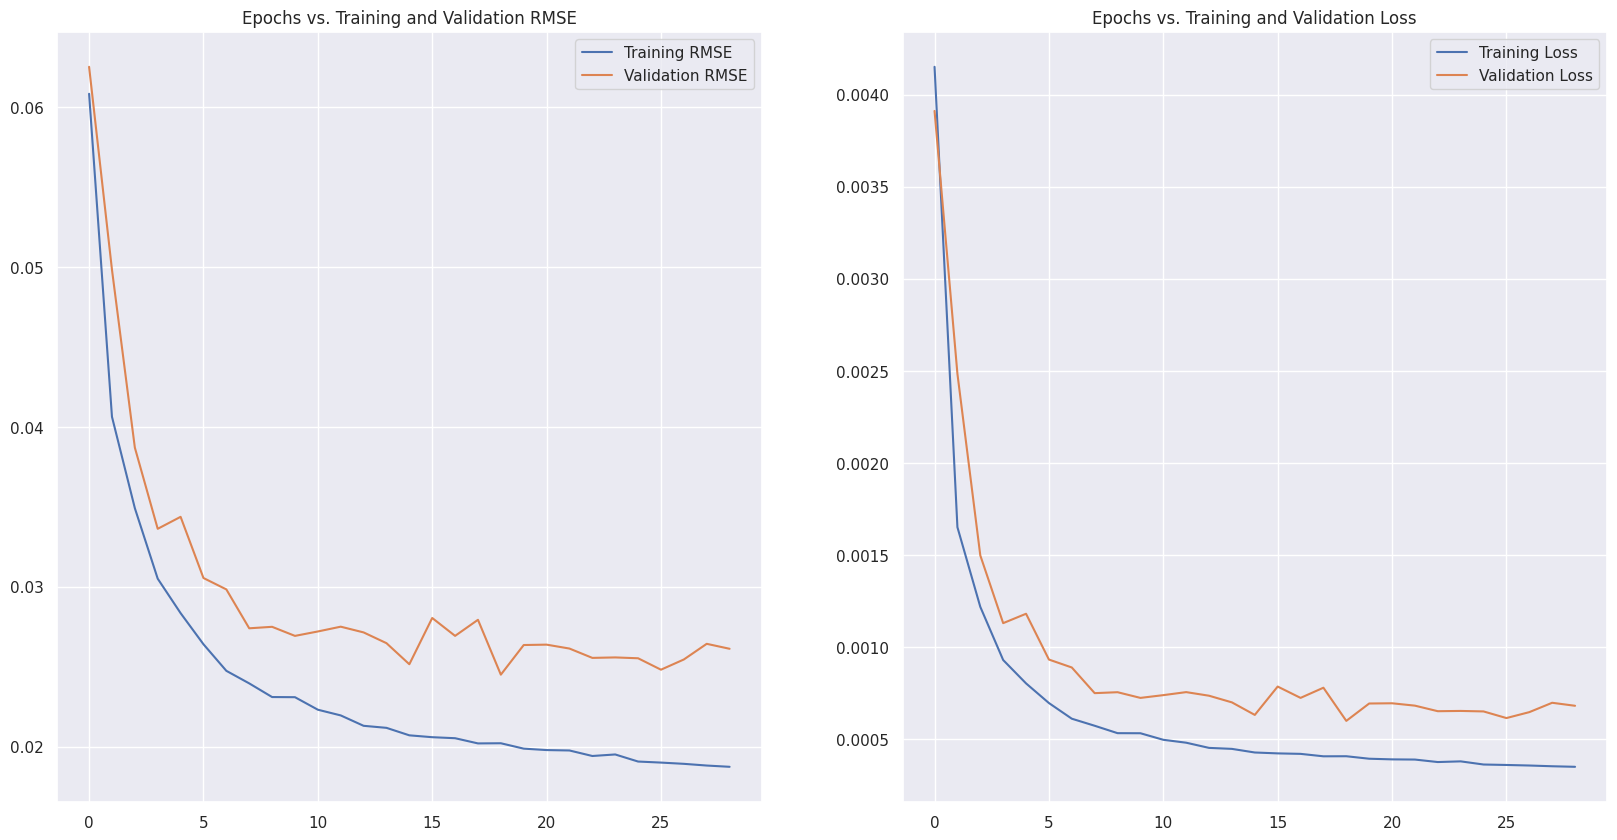

In [128]:
plot_model_rmse_and_loss(history)

In [129]:
multivariate_cnn_lstm = tf.keras.models.load_model('multivariate_cnn_lstm.h5')

forecast = multivariate_cnn_lstm.predict(X_test)
multivariate_cnn_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn_lstm = sqrt(mean_squared_error(y_test_inv,
                                             multivariate_cnn_lstm_forecast))
print('RMSE of hour-ahead electricity price multivariate CNN-`LSTM forecast: {}'
      .format(round(rmse_mult_cnn_lstm, 3)))

125/125 [==============================] - 1s 2ms/step
RMSE of hour-ahead electricity price multivariate CNN-`LSTM forecast: 2.481


In [138]:
multivariate_cnn_lstm_forecast

array([[64.854645],
       [63.2744  ],
       [64.244484],
       ...,
       [75.309105],
       [70.65249 ],
       [67.9743  ]], dtype=float32)

In [139]:
y_test_inv

array([[67.08],
       [65.19],
       [62.87],
       ...,
       [74.3 ],
       [69.89],
       [69.88]])